<h1>Сегментация и анализ клиентов интернет-магазина «Пока все ещё тут»</h1>

<h2>Цели исследования</h2>

<ol>
    <li>Исходя из анализа сегментов покупателей, разработать рекомендации о том, каким клиентам и когда следует рассылать рекламные предложения о каких категориях товаров.</li>
    <li>Разработать стратегию по увеличению количества продаваемого товара для каждого сегмента.</li>
    <li>Предложить способы повышения возвращаемости покупателей для различных сегментов.</li>
</ol>
<b>Описание данных:</b><br>
Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут».<br>
Колонки в /datasets/ecom_dataset_upd.csv:
<ul>
    <li>date - дата заказа;</li>
    <li>customer_id - идентификатор покупателя;</li>
    <li>order_id - идентификатор заказа;</li>
    <li>product - наименование товара;</li>
    <li>quantity - количество товара в заказе;</li>
    <li>price - цена товара.</li>
</ul>

<h2>Изучение данных</h2>

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.stats as st
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from statsmodels.tsa.seasonal import STL

In [59]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/ecom_dataset_upd.csv')

data.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


<h2>Предобработка данных</h2>

<h3>Поиск пропущенных значений</h3>

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


In [62]:
data.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

Пропусков в данных не вижу, во всех столбцах одинаковое количество значений.

<h3>Проверка соответствия типов</h3>

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


Типы данных во всех столбцах кроме даты выглядят корректно. Изменю формат в столбце даты на datetime.

In [64]:
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H')

data['date'].head()

0   2018-10-01
1   2018-10-01
2   2018-10-01
3   2018-10-01
4   2018-10-01
Name: date, dtype: datetime64[ns]

Теперь дата отображается корректно.

<h3>Проверка наличия дубликатов</h3>

In [65]:
data.duplicated().sum()

0

In [66]:
data.loc[data.duplicated(subset=['customer_id', 'order_id', 'product', 'quantity', 'price'])]

,date,customer_id,order_id,product,quantity,price
58,2018-10-02 18:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
59,2018-10-02 19:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
60,2018-10-02 20:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
63,2018-10-03 04:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
94,2018-10-04 13:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,Эвкалипт Гунни d-17 см h-60 см,1,1409.0
...,...,...,...,...,...,...
6706,2019-10-28 10:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0
6711,2019-10-28 21:00:00,cb65d08a-dae7-4890-aef0-bb9f79055e02,73108,Мирт d-9 см h-15 см,1,134.0
6728,2019-10-31 00:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0
6729,2019-10-31 02:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0


In [67]:
data.duplicated(subset=['customer_id', 'order_id', 'product', 'quantity', 'price']).sum()

1864

In [68]:
data = data.drop_duplicates(subset=['customer_id', 'order_id', 'product', 'quantity', 'price'])

Явные дубликаты не обнаружил. Имеется множество неявных дубликатов - заказы с одинаковыми order_id и составом, которые отражаются несколько раз в пределах нескольких часов.<br>
Исключил дубликаты, так как они будут искажать данные анализа, оставил первый лог покупки.

<h3>Проверка корректности наименования колонок</h3>

In [69]:
data.columns

Index(['date', 'customer_id', 'order_id', 'product', 'quantity', 'price'], dtype='object')

Колонки проименованы корректно, изменять ничего не буду.

### Проверка корректности логирования заказов

In [70]:
data.groupby('order_id')['customer_id'].nunique().value_counts()

customer_id
1    3492
2      26
3       2
4       1
Name: count, dtype: int64

Имеются заказы, у которых более одного покупателя. Такие данные некорректны, поэтому исключу их из датасета.

In [71]:
data = data.merge(data.groupby('order_id', as_index=False)['customer_id'].nunique().query('customer_id == 1')['order_id'])

<h3>Исследование аномальных значений</h3>

Исследуем аномальные значения на основе данных о чеках покупки.

In [72]:
data['check'] = data['price'] * data['quantity']

data.groupby('order_id')['check'].sum().describe()

count      3492.000000
mean       1317.663063
std       11593.250390
min           9.000000
25%         194.000000
50%         584.000000
75%        1271.750000
max      675000.000000
Name: check, dtype: float64

In [73]:
upper_quartile = 75
limit_of_excess = 10

check_limit = np.percentile(data.groupby('order_id')['check'].sum(), upper_quartile) * limit_of_excess

In [74]:
data.shape[0]

5544

Из выше приведенных значений можно заметить выбросы - максимальная сумма заказа 675 000, а также стандартное отклонение, которое почти в 10 раз превышает среднее значение.<br>
Ограничу чек правилом: если размер заказа больше 10 раз превышает верхний квартиль, тогда это аномалия, чтобы убрать только аномалии и не затронуть корректные заказы. 

In [75]:
data = data.merge(data.groupby('order_id', as_index=False).agg({'check':'sum'}).query('check <= @check_limit')['order_id'])

data.groupby('order_id')['check'].sum().describe()

count     3479.000000
mean      1041.865886
std       1364.616662
min          9.000000
25%        193.500000
50%        577.000000
75%       1226.500000
max      11460.000000
Name: check, dtype: float64

Теперь данные выглядят более понятно, максимум стал значительное меньше, а стандартное отклонение приблизилось к среднему значению. При этом было убрано всего около 1% заказов.<br>
Визализирую распределение чеков, чтобы информация была более наглядной.

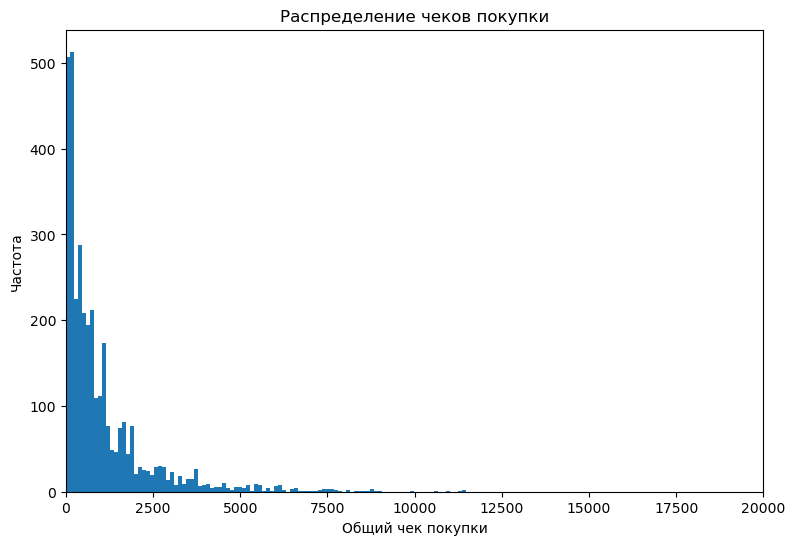

In [76]:
data.groupby('order_id')['check'].sum().plot(kind='hist', bins=100, figsize=(9,6), xlim=(0, 20000))
plt.title('Распределение чеков покупки')
plt.xlabel('Общий чек покупки')
plt.ylabel('Частота')
plt.show()

На график также видно, что большинство покупок не превышает 1000 рублей.

Также проверю аномалии относительно количества заказов.

In [77]:
data.groupby('customer_id')['order_id'].nunique().describe()

count    2404.000000
mean        1.447171
std         2.702497
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       126.000000
Name: order_id, dtype: float64

Медиана и среднее значение близки к 1, однако видно аномальное значение максимального количества покупок - 126, оно может исказить результаты исследования, так как я хочу найти общие тренды для дальнейших рекомендаций.  

Ограничу количество заказов 99 перцентилем, чтобы отсечь выбросы и при этом потерять небольшое количество данных.

In [78]:
number_of_order_limit = np.percentile(data.groupby('customer_id')['order_id'].nunique(), upper_quartile) * limit_of_excess

data = data.merge(data.groupby('customer_id', as_index=False)['order_id'].nunique().query('order_id <= @number_of_order_limit')['customer_id'])

В ходе предобработки данных:
<ul>
    <li>изменен тип данных даты и времени на корректный;</li>
    <li>убраные неявные дубликаты;</li>
    <li>чек ограничен до 99 перцентиля для анализа общего тренда;</li>
    <li>количество покупок огранично до 99 перцентиля;</li>
    <li>убраны заказы, у которых несколько покупателей.</li>
</ul>

<h2>Исследовательский анализ данных</h2>

<h3>Исследование динамики выручки</h3>

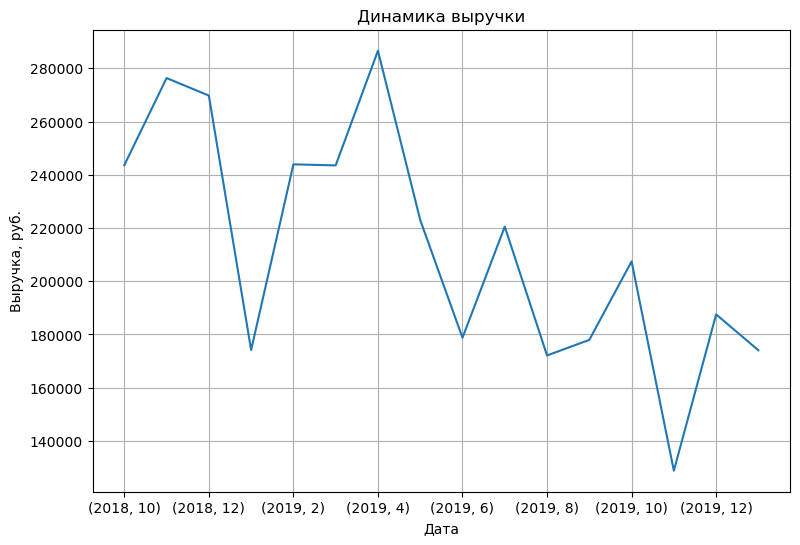

In [79]:
data.groupby([data['date'].dt.year, data['date'].dt.month])['check'].sum().plot(figsize=(9,6), grid=True)
plt.title('Динамика выручки')
plt.xlabel('Дата')
plt.ylabel('Выручка, руб.')
plt.show()

Общая динамика выручки удручает, виден явный тренд на снижение, общая выручка с течением времени падает.

<h3>Исследование среднего чека и его динамики</h3>

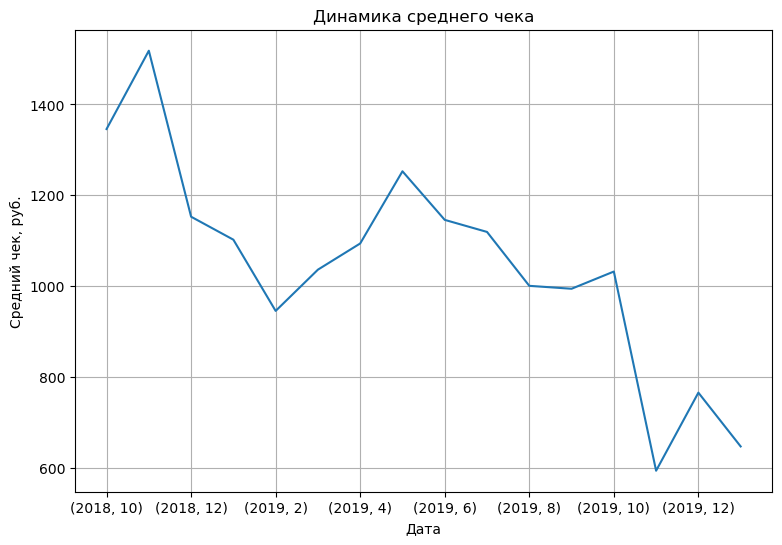

In [80]:
((data.groupby([data['date'].dt.year, data['date'].dt.month])['check'].sum() / 
 data.groupby([data['date'].dt.year, data['date'].dt.month])['order_id'].nunique()).plot(figsize=(9,6), grid=True))
plt.title('Динамика среднего чека')
plt.ylabel('Средний чек, руб.')
plt.xlabel('Дата')
plt.show()

Динамика среднего чека в целом сопоставима с динамикой выручки. Также виден явный тренд на снижение.

<h3>Исследование динамики средней выручки с покупателя</h3>

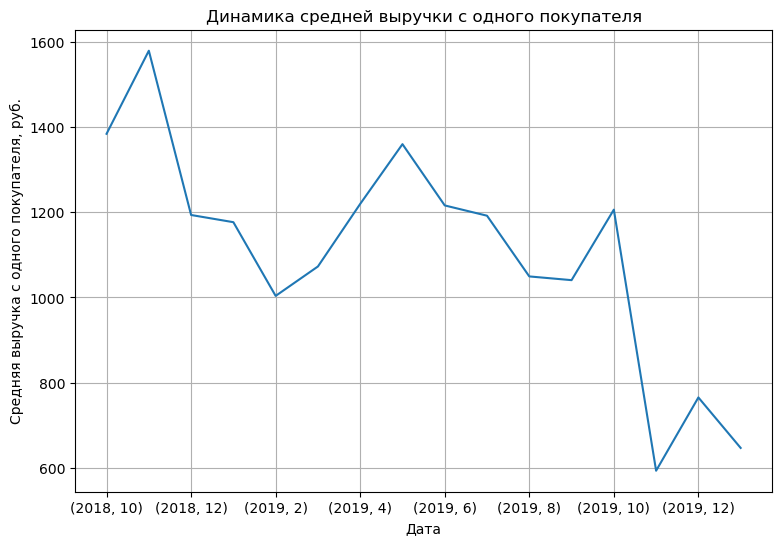

In [81]:
((data.groupby([data['date'].dt.year, data['date'].dt.month])['check'].sum() / 
  data.groupby([data['date'].dt.year, data['date'].dt.month])['customer_id'].nunique()).plot(figsize=(9,6), grid=True))
plt.title('Динамика средней выручки с одного покупателя')
plt.xlabel('Дата')
plt.ylabel('Средняя выручка с одного покупателя, руб.')
plt.show()

Графики среднего чека и средней выручки с одного покупателя имеют схожую динамику, тренд на снижение.

<h2>Основные вопросы исследования</h2>

### Определение числа сегментов с помощью агломеративной иерархической классификации

In [82]:
current_date = data['date'].max()

user_data = data.groupby('customer_id').agg(
    total_spending=('check', 'sum'),
    num_purchases=('order_id', 'nunique'),
    purchase_frequency=('date', lambda x: (x.max() - x.min()).days / x.nunique() if x.nunique() > 1 else (current_date - x.max()).days)
).reset_index()

user_data['average_check'] = user_data['total_spending'] / user_data['num_purchases']
user_data['time_to_last_order'] = (data['date'].max() - data.groupby('customer_id', as_index=False)['date'].max()['date']).apply(lambda x: x.total_seconds())

sc = StandardScaler()
user_data_sc = sc.fit_transform(user_data.drop(columns=['customer_id']))

linked = linkage(user_data_sc, method = 'ward')

Для агломеративной иерархической классификации и дальнейшей кластеризации с помощью k-means, я выбрал следующие признаки, которые всесторонне описывают покупателей и специфику их поведения:
<ul>
    <li>общая сумма покупок;</li>
    <li>средний чек;</li>
    <li>количество покупок;</li>
    <li>частота покупок;</li>
    <li>количество времени, прошедшее с момента последней покупки.</li>
</ul>

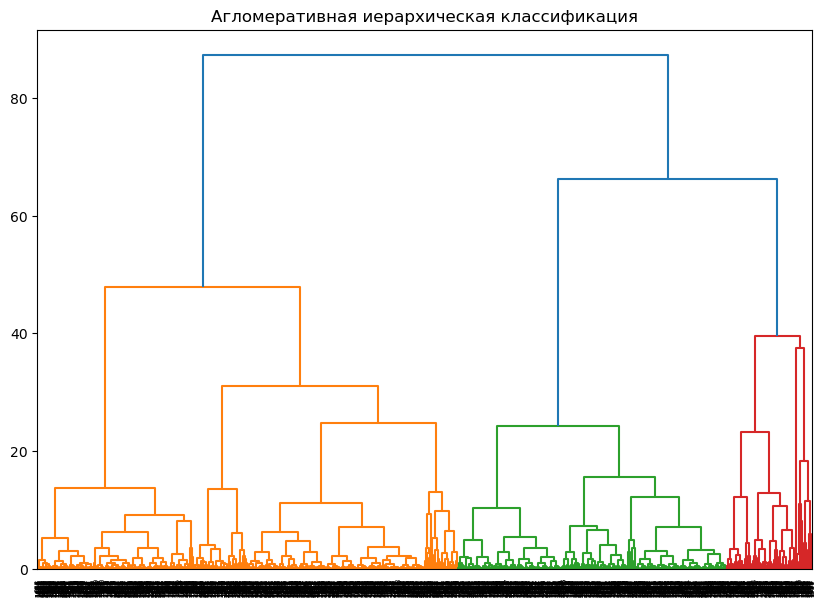

In [83]:
plt.figure(figsize=(10, 7))  
dendrogram(linked, orientation='top')
plt.title('Агломеративная иерархическая классификация')
plt.show()

Исходя из дендрограммы, оптимальное количество кластеров - 3, именно такое количество использую в k-means.

### Сегментация пользователей при помощи метода k-means

In [84]:
km = KMeans(n_clusters=3, random_state=0)
labels = km.fit_predict(user_data_sc)

user_data['cluster_km'] = labels
user_data['time_to_last_order'] = user_data['time_to_last_order'] / 86400

user_data.groupby('cluster_km').count()['customer_id']

cluster_km
0    1030
1    1183
2     189
Name: customer_id, dtype: int64

In [85]:
user_data.drop('customer_id', axis=1).groupby('cluster_km').mean()

,total_spending,num_purchases,purchase_frequency,average_check,time_to_last_order
cluster_km,,,,,
0,929.831068,1.022330,349.602913,915.107767,350.457484
1,1131.116864,1.679628,122.415670,682.248111,98.399021
2,5883.746914,1.470899,208.140653,4466.959150,207.697090


Исходя из средних значений параметров различных кластеров, можно обозначить кластеры следующим образом:
<ul>
    <li>0 - регулярные пользователи, которые чаще всех делают покупки, но на небольшую сумму.</li>
    <li>1 - ушедшие пользователи, которые совершили только одну покупку.</li>
    <li>2 - пользователи, которые делают покупки не часто, но на крупную сумму.</li>
</ul>
Для простоты восприятия назову их: regular_small, past и inactive_big, соответственно.

In [86]:
user_data.loc[user_data['cluster_km'] == 0, 'cluster_km'] = 'regular_small'
user_data.loc[user_data['cluster_km'] == 1, 'cluster_km'] = 'past'
user_data.loc[user_data['cluster_km'] == 2, 'cluster_km'] = 'inactive_big'

data = data.merge(user_data[['customer_id', 'cluster_km']], how='left')

C:\Users\stepa\AppData\Local\Temp\ipykernel_2508\4112419297.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'regular_small' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  user_data.loc[user_data['cluster_km'] == 0, 'cluster_km'] = 'regular_small'


### Исследование частоты покупок по сегментам

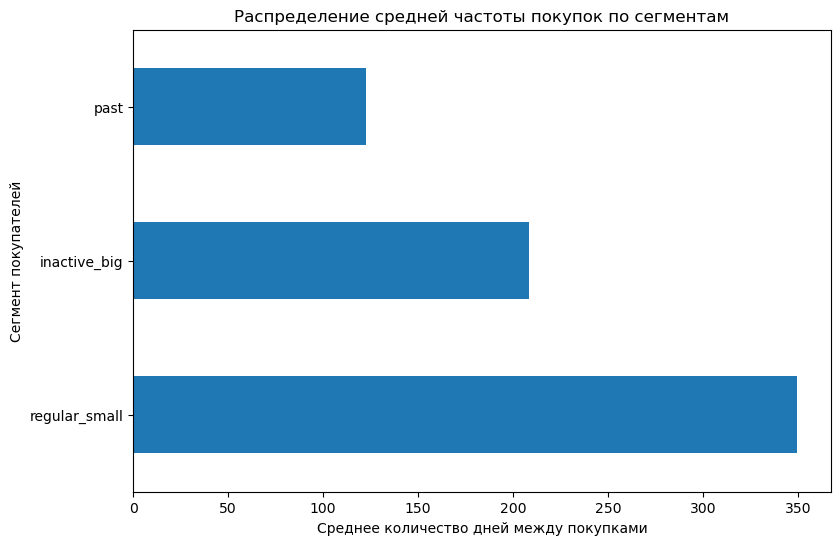

In [87]:
user_data.groupby('cluster_km')['purchase_frequency'].mean().sort_values(ascending=False).plot(kind='barh', figsize=(9,6))

plt.title('Распределение средней частоты покупок по сегментам')
plt.ylabel('Сегмент покупателей')
plt.xlabel('Среднее количество дней между покупками')
plt.show()

Ожидаемо чаще всего покупки совершали постоянные покупатели, затем идут неактивные, затем ушедшие.

### Исследование среднего количество покупок на пользователя по сегментам

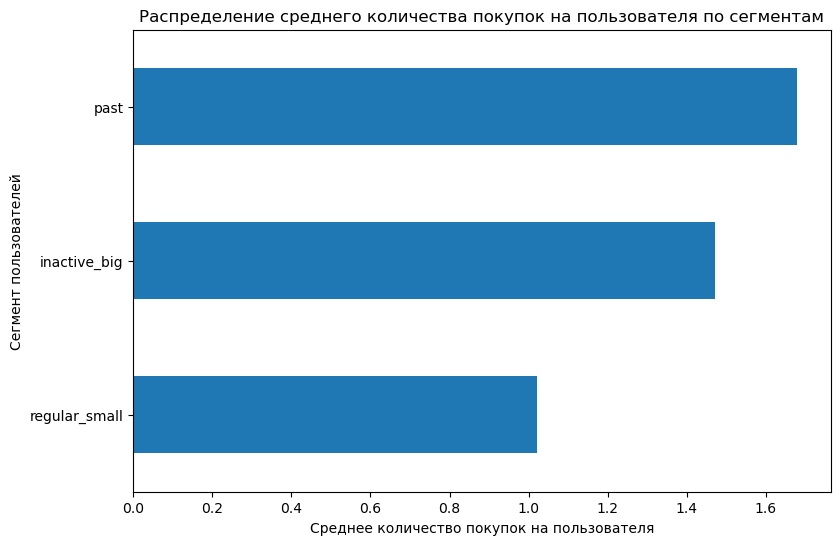

In [88]:
user_data.groupby('cluster_km')['num_purchases'].mean().sort_values().plot(kind='barh', figsize=(9,6))

plt.title('Распределение среднего количества покупок на пользователя по сегментам')
plt.ylabel('Сегмент пользователей')
plt.xlabel('Среднее количество покупок на пользователя')
plt.show()

Наибольшее среднее количество покупок на пользователя у сегмента постоянных покупателей, затем идут неактивные и ушедшие пользователи. Такое логичное распределение косвенно подтверждает правильность сегментации.

### Исследование распределения количества покупок в течение года

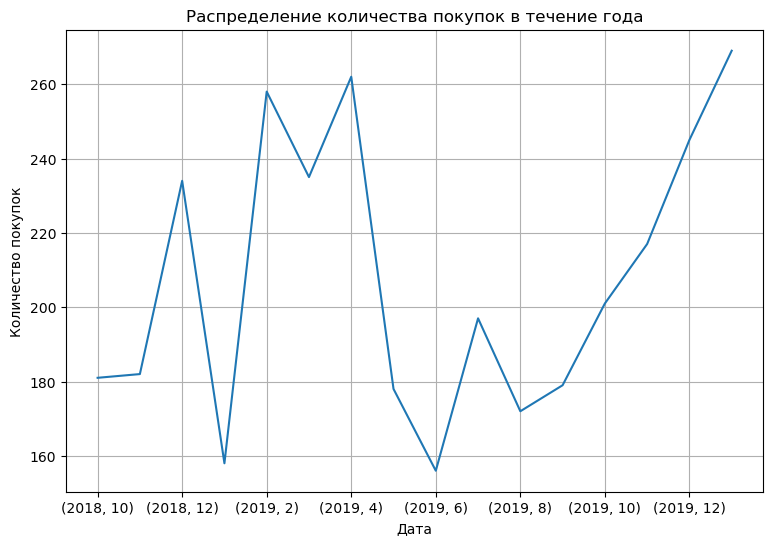

In [89]:
(data.groupby([data['date'].dt.year, data['date'].dt.month])['order_id']
 .nunique()
 .plot(grid=True, figsize=(9,6)))

plt.title('Распределение количества покупок в течение года')
plt.ylabel('Количество покупок')
plt.xlabel('Дата')
plt.show()

По графику видно, что пик общего количества покупок приходится на декабрь и февраль-апрель.

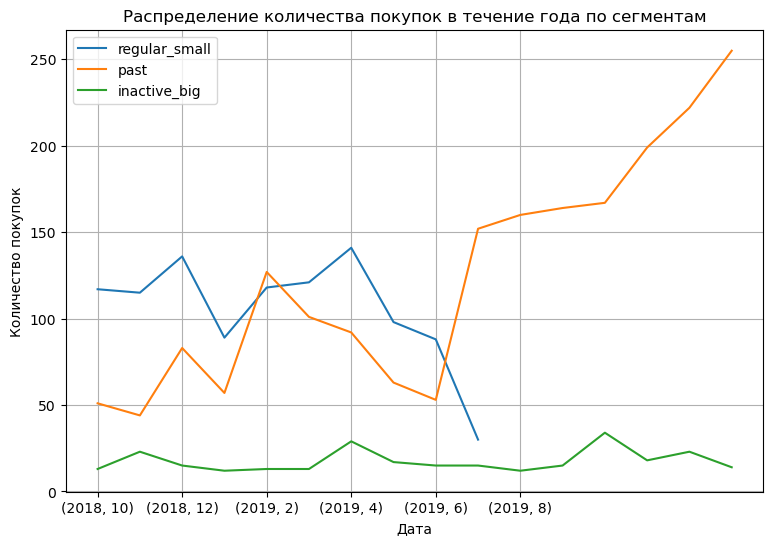

In [90]:
names = []

for i in data['cluster_km'].unique():
    (data.query('cluster_km == @i')
     .groupby([data['date'].dt.year, data['date'].dt.month])['order_id']
     .nunique()
     .plot(grid=True, figsize=(9,6)))
    names.append(i)
    
plt.legend(names)
plt.title('Распределение количества покупок в течение года по сегментам')
plt.ylabel('Количество покупок')
plt.xlabel('Дата')
plt.show()

У ушедших пользователей нет покупок позже августа, у неактивных пользователей с высоким чеком небольшое количество покупок в течение всего периода, а количество покупок регулярных пользователей растет ближе к концу периода

### Исследование величины среднего чека по сегментам 

In [91]:
user_data.groupby('cluster_km')['average_check'].mean()

cluster_km
inactive_big     4466.959150
past              682.248111
regular_small     915.107767
Name: average_check, dtype: float64

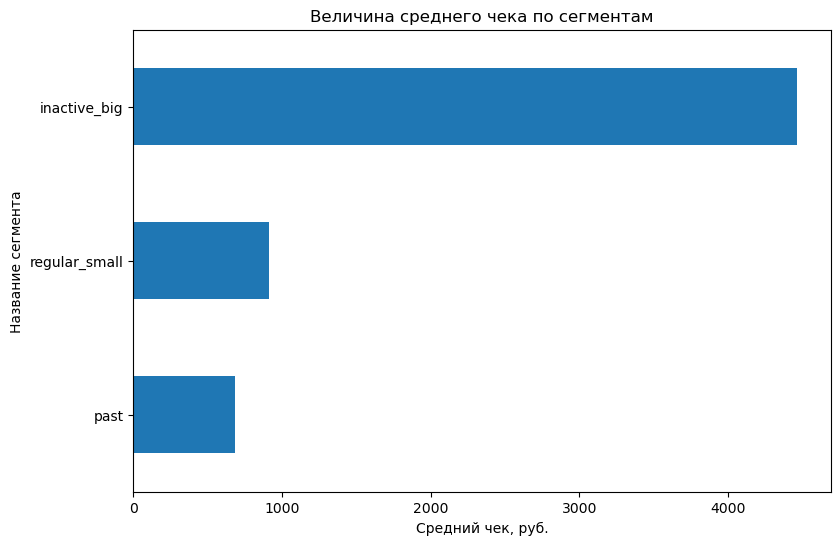

In [92]:
(user_data.groupby('cluster_km')['average_check'].mean()
 .sort_values()
 .plot(kind='barh', figsize=(9,6)))

plt.title('Величина среднего чека по сегментам')
plt.xlabel('Средний чек, руб.')
plt.ylabel('Название сегмента')
plt.show()

Наибольший средний чек у сегмента неактивных пользователей с высокими тратами, затем идут ушедшие пользователи и регулярные. В плане одноразовой покупки сегмент неактивных пользователей для нас самый привлекательный.

### Исследование общей выручки в разрезе сегментов

In [93]:
(data.groupby('cluster_km')['check'].sum() / 100)

cluster_km
inactive_big     11120.281667
past             13381.112500
regular_small     9577.260000
Name: check, dtype: float64

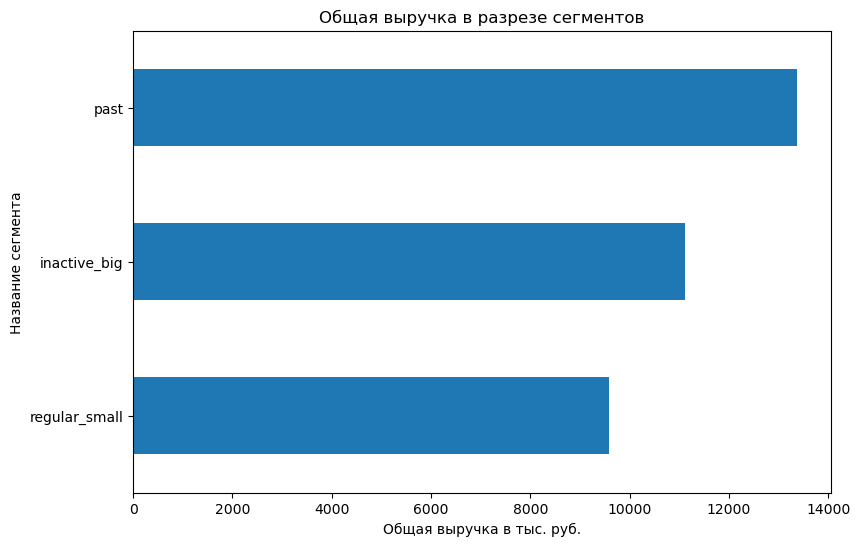

In [94]:
(data.groupby('cluster_km')['check'].sum() / 100).sort_values().plot(kind='barh', figsize=(9,6))

plt.title('Общая выручка в разрезе сегментов')
plt.ylabel('Название сегмента')
plt.xlabel('Общая выручка в тыс. руб.')
plt.show()

Общая выручка неактивных пользователей сопоставима с регулярными при том, что их в 6 раз меньше по количеству.

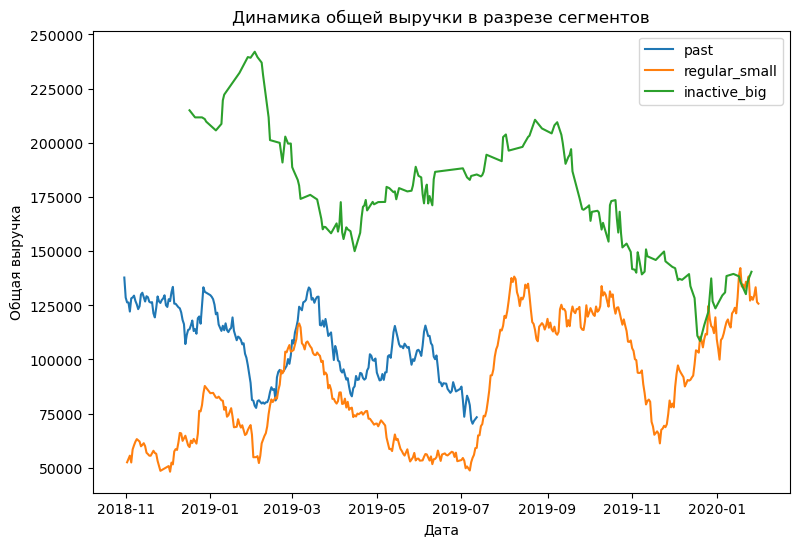

In [95]:
plt.figure(figsize=(9,6))

for cluster_km in data['cluster_km'].unique():
    data.query('cluster_km == @cluster_km').groupby([data['date'].dt.date])['check'].sum().rolling(window=30).sum().plot.line()

plt.legend(['past', 'regular_small', 'inactive_big'])
plt.title('Динамика общей выручки в разрезе сегментов')
plt.xlabel('Дата')
plt.ylabel('Общая выручка')
plt.show()

По графику динамики выручки можно сделать следующие выводы:
<ul>
    <li>Выручка ушедших пользователей падает, так как их количество снижается с течением времени.</li>
    <li>Выручка неактивных пользователей падает несмотря на то, что изменений в количестве покупок практически не наблюдается. Вероятнее всего, это связано с падением среднего чека данного сегмента.</li>
    <li>Выручка от регулярных пользователей имеют тренд на повышение, однако это связано, в первую очередь, с увеличением количества заказов.</li>
</ul>

### Исследовать основные категории товаров и их сезонность

С помощью регулярных выражений разделю по категориям основную часть товаров.<br>
Основная категория - это товары для дома и декора, поэтому я сначала добавлю всех в эту категорию, а затем вручную отберу из нее другие категории.

In [96]:
data.loc[data['product'].str.contains(r'[a-zA-Zа-яА-ЯёЁ0-9]+(?:\s+[a-zA-Zа-яА-ЯёЁ0-9]+)*', regex=True), 'product_category'] = 'товары для дома и декора'
data.loc[data['product'].str.contains(r'\b([Тт]ележк[аи]|[Чч]ехол|[Кк]оробка)\b', regex=True), 'product_category'] = 'товары для транспортировки'
data.loc[data['product'].str.contains(r'\b[dhDH][- ]?\d+(-\d+)?\b|\b[Сс]орт\b|\b[Рр]ассада\b|\b[Пп]еларгония\b|\b[Рр]астение\b|\b[Оо]бъем\b|\bдиам\.|\b[Рр]оза\b|\b(кассете|Цикламен|Тюльпан|Ранункулус|Стелла|Осина|Р-?\d|горш(ке|ок)|Антуриум|Алиссум|Вербейник|Гвоздика|Георгина|Гиностемма|Кодонанта|Гипсофила|Годеция|Горох|Дендробиум|Ель|Зверобой|Календула|Калла|Космея|кашпо|4660010\d*|46500\d*)\b', regex=True), 'product_category'] = 'растения'
data.loc[data['product'].str.contains(r'\b[Сс]тремянк[аи]\b|\bванн(ой|у)\b|\b[Пп]олк[аи]\b|\b([Кк]арниз|Крепеж|[Кк]рючок|Фал|Сиденье|[Cc]верло|пробки|напильников|110|Кольца|угольник)\b', regex=True), 'product_category'] = 'товары для ремонта'

C:\Users\stepa\AppData\Local\Temp\ipykernel_2508\3321749331.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data.loc[data['product'].str.contains(r'\b([Тт]ележк[аи]|[Чч]ехол|[Кк]оробка)\b', regex=True), 'product_category'] = 'товары для транспортировки'
C:\Users\stepa\AppData\Local\Temp\ipykernel_2508\3321749331.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data.loc[data['product'].str.contains(r'\b[dhDH][- ]?\d+(-\d+)?\b|\b[Сс]орт\b|\b[Рр]ассада\b|\b[Пп]еларгония\b|\b[Рр]астение\b|\b[Оо]бъем\b|\bдиам\.|\b[Рр]оза\b|\b(кассете|Цикламен|Тюльпан|Ранункулус|Стелла|Осина|Р-?\d|горш(ке|ок)|Антуриум|Алиссум|Вербейник|Гвоздика|Георгина|Гиностемма|Кодонанта|Гипсофила|Годеция|Горох|Дендробиум|Ель|Зверобой|Календула|Калла|Космея|кашпо|4660010\d*|46500\d*)\b', regex=True), 'product_category'] = 'растения'
C:\User

Получились 4 основные категории:
<ul>
    <li>товары для транспортировки;</li>
    <li>растения;</li>
    <li>товары для дома и декора;</li>
    <li>товары для ремонта.</li>
</ul>
Посмотрю на их сезонность.

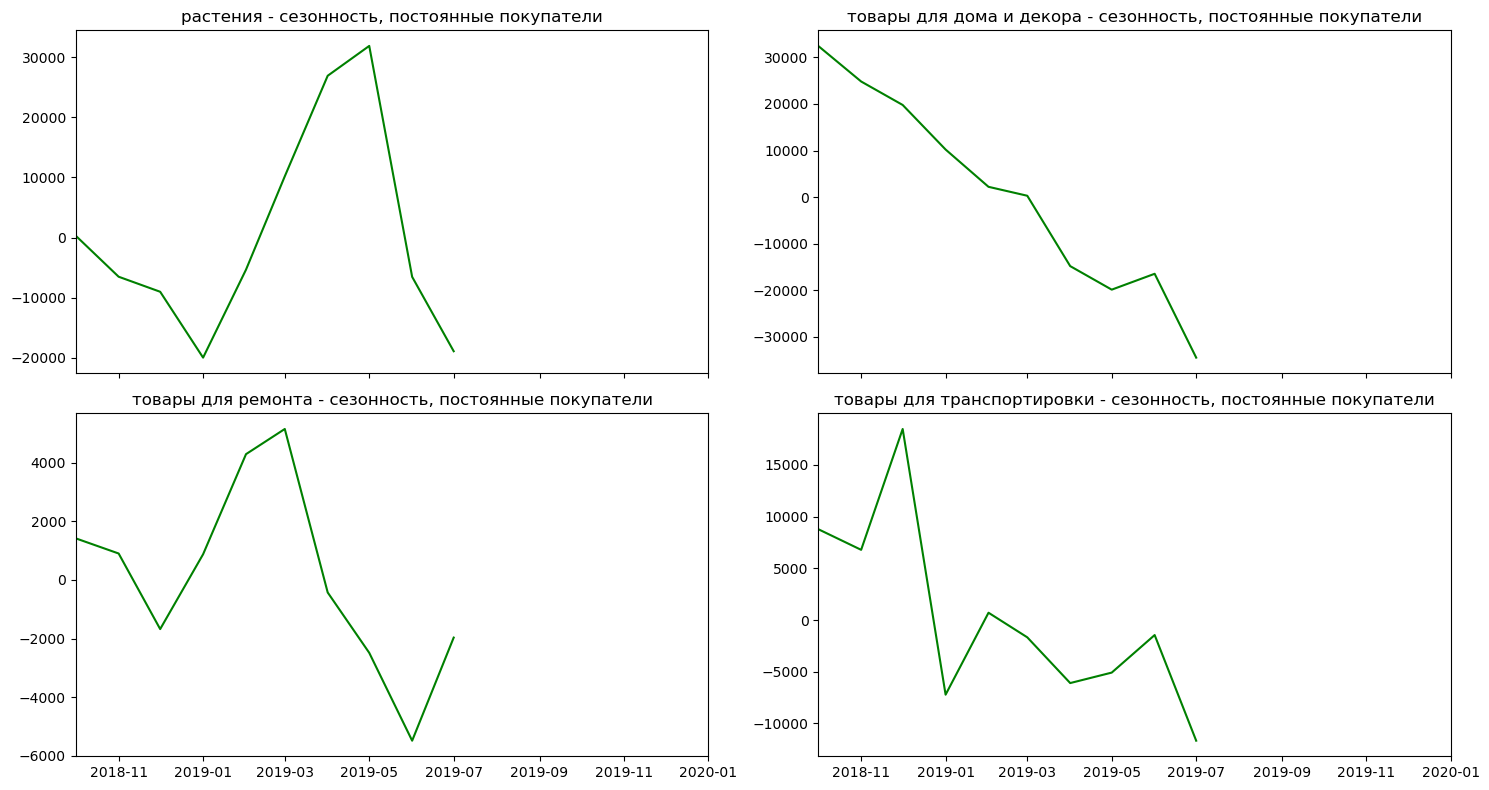

In [97]:
x_limits = [pd.Timestamp('2018-10-01'), pd.Timestamp('2020-01-01')]
full_index = pd.date_range(start='2018-10-01', end='2020-01-01', freq='MS')

def show_seasonality(cluster, cluster_name):
    season = data.query('cluster_km == @cluster').copy()

    season["month"] = season["date"].dt.to_period("M")  

    season_grouped = season.groupby(["month", "product_category"])["check"].sum().unstack()

    season_grouped.index = season_grouped.index.to_timestamp()
    
    season_grouped = season_grouped.reindex(full_index)

    fig, axes = plt.subplots(2, 2, figsize=(15,8), sharex=True)
    axes = axes.flatten() 

    for ax, category in zip(axes, season_grouped.columns):
        stl = STL(season_grouped[category].dropna(), period=12)
        result = stl.fit()

        ax.plot(result.seasonal, label="Сезонность", color="green")
        ax.set_title(f"{category} - сезонность, {cluster_name}")
        ax.set_xlim(x_limits)

    plt.tight_layout()
    plt.show()
    
show_seasonality('regular_small', 'постоянные покупатели')

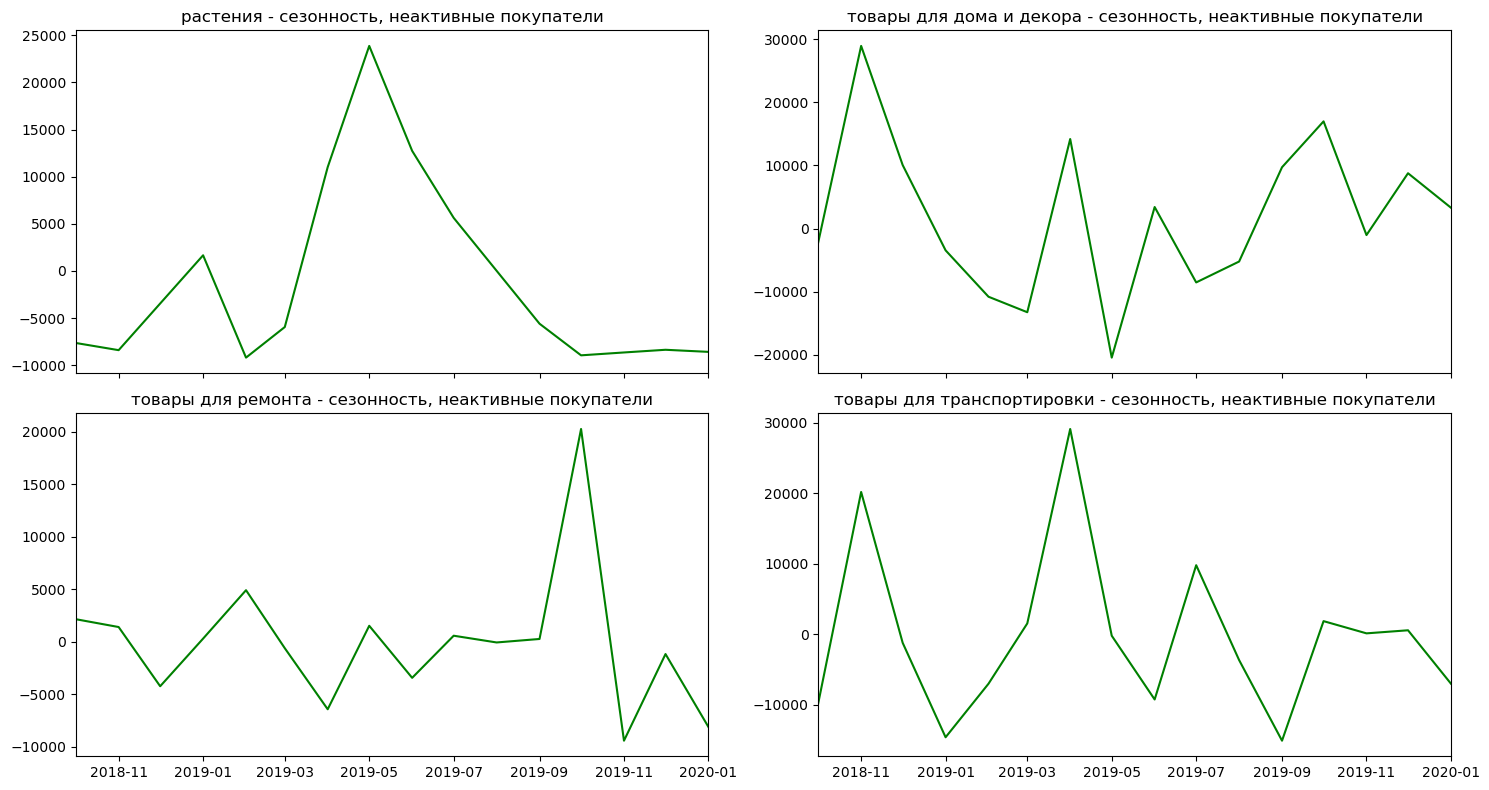

In [98]:
show_seasonality('inactive_big', 'неактивные покупатели')

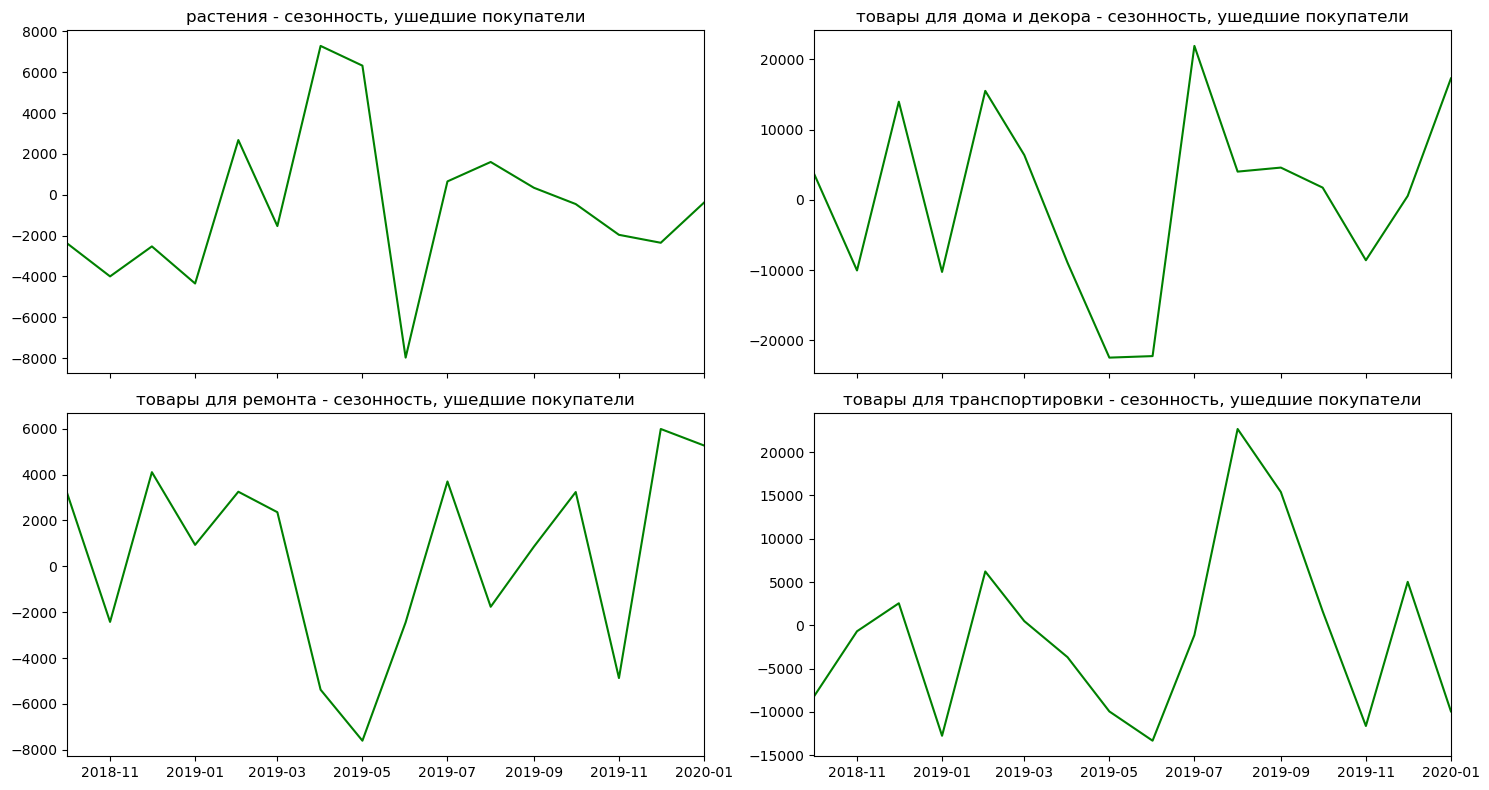

In [99]:
show_seasonality('past', 'ушедшие покупатели')

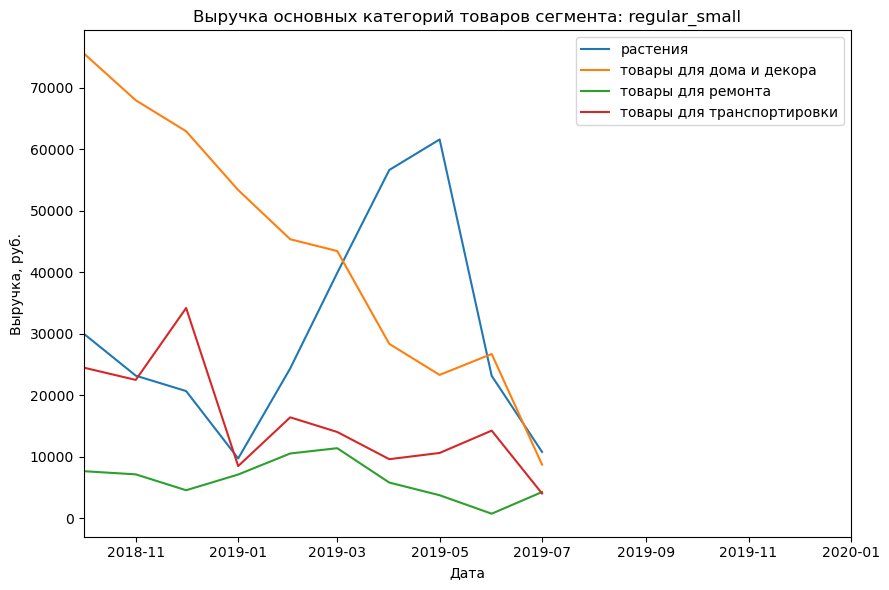

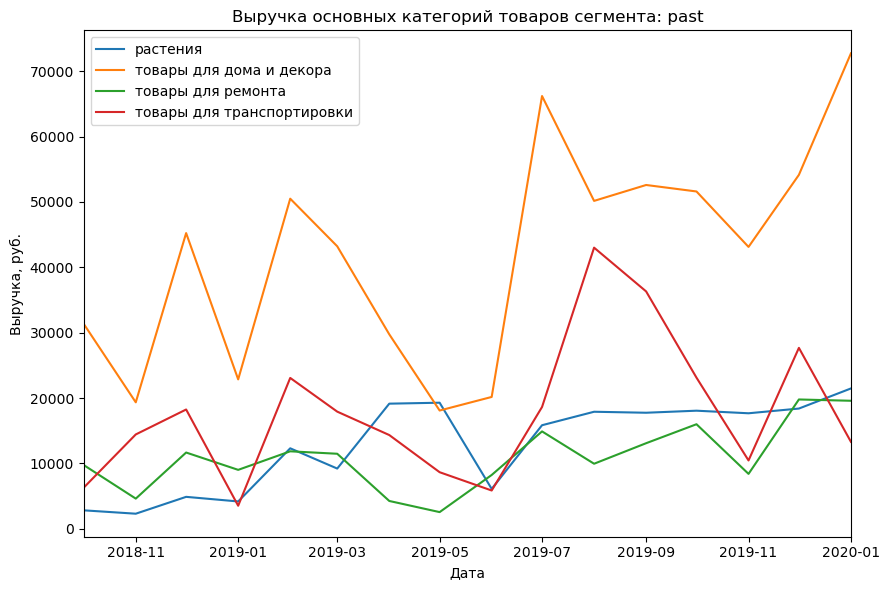

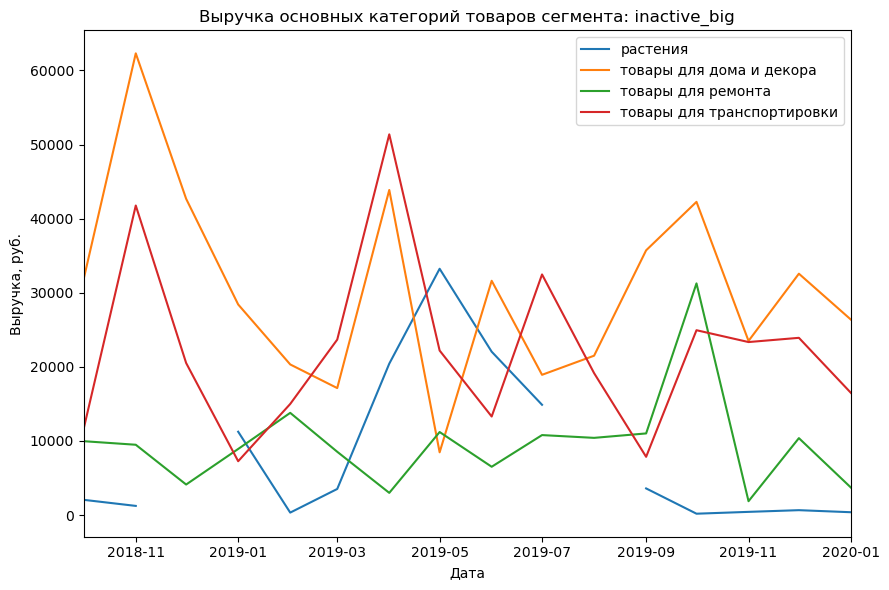

In [100]:
for cluster in data['cluster_km'].unique():
    category = []
    plt.figure(figsize=(9, 6))
    
    for product_category in data['product_category'].unique():
        df = data.query('product_category == @product_category and cluster_km == @cluster').copy()
        
        df["month"] = df["date"].dt.to_period("M")

        df_grouped = df.groupby(["month", "product_category"])["check"].sum().unstack()

        df_grouped.index = df_grouped.index.to_timestamp()

        df_grouped = df_grouped.reindex(full_index)
        
        plt.plot(df_grouped.index, df_grouped[product_category], label=product_category)
        
        category.append(product_category)
        
    plt.title(f'Выручка основных категорий товаров сегмента: {cluster}')
    plt.xlabel('Дата')
    plt.ylabel('Выручка, руб.')
    plt.legend(category)
    
    plt.xlim(x_limits)

    plt.tight_layout()
    plt.show()

На основании этих графиков будут формироваться рекомендации по персональным предложениям различным сегементам пользователей.  
Первые графики проще интерпретировать для рекомендаций, а вторые - использовать в презентации, так как все категории собраны на нескольких графиках.

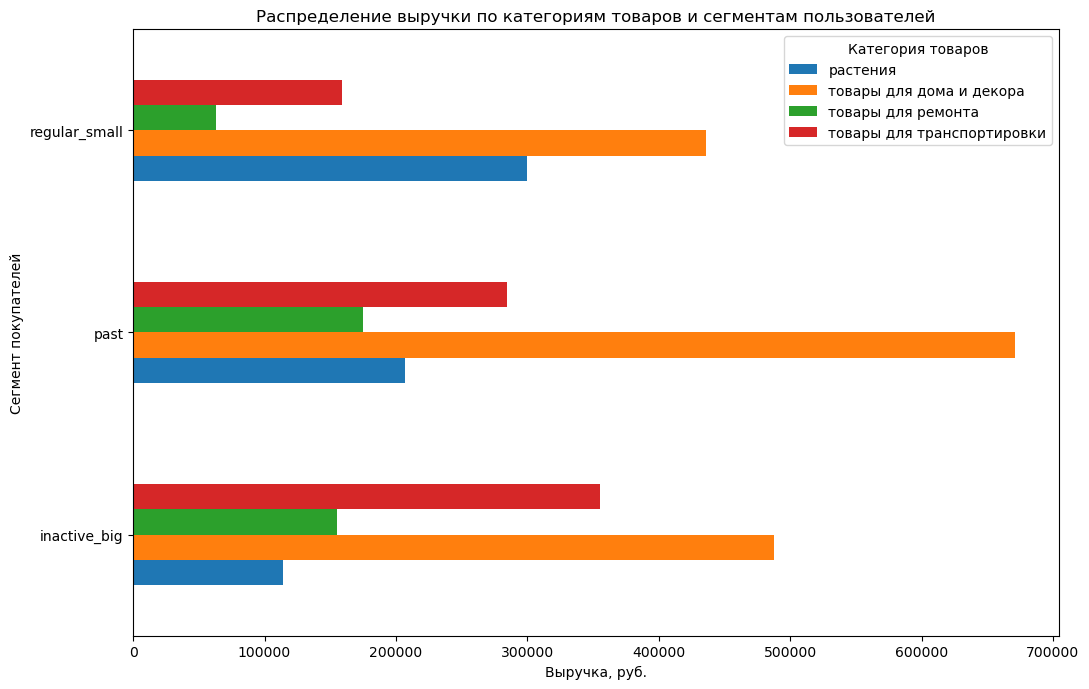

In [101]:
data.groupby(['cluster_km', 'product_category'])['check'].sum().unstack().plot(kind='barh', figsize=(11,7))
plt.title('Распределение выручки по категориям товаров и сегментам пользователей')
plt.xlabel('Выручка, руб.')
plt.ylabel('Сегмент покупателей')
plt.legend(title='Категория товаров')
plt.tight_layout()
plt.show()

Разные сегменты пользователей покупают разные товары:
<ul>
    <li>Все сегменты потраталили больше всего средств на товары для дома и декора, так как это основная категория нашего магазина.</li>
    <li>Постоянные и новые пользователи больше всех покупают товары для дома и декора.</li>
    <li>Ушедшие клиенты большую часть средств потратили на растения.</li>
    <li>Неактивные пользователи покупали товары для транспортировки больше всех среди других категорий.</li>
</ul>

## Проверка гипотез

Проверим сегментацию на корректность, если между сегментами не будет различий ни в среднем чеке, ни в среднем количестве покупок, значит, сегментация проведена некорректно.

### Гипотеза о равенстве средних чеков

H0: Средний чек сегментов не имеет статистически значимых различиий.<br>
H1: Средний чек сегментов имеет статистически значимые различия.

In [102]:
alpha = 0.05 / 6

past_check = data.query('cluster_km == "past"').groupby('order_id')['check'].sum().copy()
inactive_big_check = data.query('cluster_km == "inactive_big"').groupby('order_id')['check'].sum().copy()
regular_small_check = data.query('cluster_km == "regular_small"').groupby('order_id')['check'].sum().copy()


def compare_samples(sample_1, sample_2, name_of_var, name_of_sample_1, name_of_sample_2):
    results = st.ttest_ind(sample_1, sample_2)
    
    print(f'Среднее значение переменной {name_of_var} в выборке {name_of_sample_1}:', sample_1.mean())
    print(f'Среднее значение переменной {name_of_var} в выборке {name_of_sample_2}:', sample_2.mean())

    p_value = results.pvalue

    print('Значение p_value:', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между средними есть статистически значимая разница.')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать средние разными.')
    print()

compare_samples(past_check, inactive_big_check, 'чек', 'ушедшие пользователи', 'неактивные пользователи')
compare_samples(past_check, regular_small_check, 'чек', 'ушедшие пользователи', 'постоянные пользователи')
compare_samples(inactive_big_check, regular_small_check, 'чек', 'неактивные пользователи', 'постоянные пользователи')

Среднее значение переменной чек в выборке ушедшие пользователи: 673.4329391041772
Среднее значение переменной чек в выборке неактивные пользователи: 4000.1013189448445
Значение p_value: 0.0
Отвергаем нулевую гипотезу: между средними есть статистически значимая разница.

Среднее значение переменной чек в выборке ушедшие пользователи: 673.4329391041772
Среднее значение переменной чек в выборке постоянные пользователи: 909.5213675213676
Значение p_value: 3.3534476159323947e-16
Отвергаем нулевую гипотезу: между средними есть статистически значимая разница.

Среднее значение переменной чек в выборке неактивные пользователи: 4000.1013189448445
Среднее значение переменной чек в выборке постоянные пользователи: 909.5213675213676
Значение p_value: 8.56440263167563e-189
Отвергаем нулевую гипотезу: между средними есть статистически значимая разница.



### Гипотеза о равенстве среднего количества покупок

H0: Среднее количество покупок между сегментами не имеет статистически значимых различий.<br>
H1: Среднее количество покупок между сегментами имеет статистически значимые различия.

In [103]:
past_orders = data.query('cluster_km == "past"').groupby('customer_id')['order_id'].nunique()
inactive_big_orders = data.query('cluster_km == "inactive_big"').groupby('customer_id')['order_id'].nunique()
regular_small_orders = data.query('cluster_km == "regular_small"').groupby('customer_id')['order_id'].nunique()

compare_samples(past_orders, inactive_big_orders, 'количество покупок', 'ушедшие пользователи', 'неактивные пользователи')
compare_samples(past_orders, regular_small_orders, 'количество покупок', 'ушедшие пользователи', 'новые и постоянные пользователи')
compare_samples(inactive_big_orders, regular_small_orders, 'количество покупок', 'неактивные пользователи', 'новые и ушедшие пользователи')

Среднее значение переменной количество покупок в выборке ушедшие пользователи: 1.679628064243449
Среднее значение переменной количество покупок в выборке неактивные пользователи: 1.470899470899471
Значение p_value: 9.979990797273674e-05
Отвергаем нулевую гипотезу: между средними есть статистически значимая разница.

Среднее значение переменной количество покупок в выборке ушедшие пользователи: 1.679628064243449
Среднее значение переменной количество покупок в выборке новые и постоянные пользователи: 1.0223300970873785
Значение p_value: 1.199717927479384e-241
Отвергаем нулевую гипотезу: между средними есть статистически значимая разница.

Среднее значение переменной количество покупок в выборке неактивные пользователи: 1.470899470899471
Среднее значение переменной количество покупок в выборке новые и ушедшие пользователи: 1.0223300970873785
Значение p_value: 1.7685503388582883e-27
Отвергаем нулевую гипотезу: между средними есть статистически значимая разница.



Я использовал ttest_ind, так как он предназначен для сравнения средних двух независимых генеральных совокупностей, с чем я и имею дело. Также я использовал поправку Бонферрони, чтобы уменьшить групповую вероятность ошибки первого рода, которая возникает из-за попарных сравнений.

Так как по каждому сравнению сегментов оба т-тест показали статистически значимую разницу - сегментация была проведена корректно.

## Ответы на вопросы исследования

Основные показатели интернет-магазина:
<ul>
    <li>Выручка имеет отрицательную динамику, за 16 месяцев она сократилась более чем на 33%.</li>
    <li>Средний чек также имеет отрицательную динамику, за исследуемый период он сократился в два раза.</li>
    <li>Средняя выручка с одного покупателя также падает, за данный период она снизилась в два раза.</li>
</ul>
Таким образом, все основные показатели интернет-магазина имеют отрицательную динамику.<br>
В ходе анализа я разделил покупателей на три сегмента (кластера) методом k-means и проанализировал их поведение:
<ul>
    <li>regular_small - регулярные пользователи, которые чаще всех делают покупки, но на небольшую сумму.</li>
    <li>past - ушедшие пользователи, которые совершили только одну покупку.</li>
    <li>inactive_big - пользователи, которые делают покупки не часто, но на крупную сумму.</li>
</ul>
Также я распределил все товары на 4 категории:
<ul>
    <li>товары для транспортировки;</li>
    <li>растения;</li>
    <li>товары для дома и декора;</li>
    <li>товары для ремонта.</li>
</ul>
Рекомендации по маркетингу для разных сегментов сделаны исходя из повышения/снижения спроса на какую-либо категорию товаров в определенный месяц для определенного сегмента.  

Рекомендации по маркетингу для <b>сегмента регулярных пользователей, которые чаще всех делают покупки, но на небольшую сумму</b> (regular_small):
<ul>
    <li>январь: товары для дома и декора;</li>
    <li>февраль: растения, товары для дома и декора, товары для ремонта;</li>
    <li>март: товары для транспортировки;</li>
    <li>апрель: растения;</li>
    <li>май: растения;</li>
    <li>июнь: товары для ремонта;</li>
    <li>июль: товары для ремонта;</li>
    <li>август: товары для транспортировки;</li>
    <li>сентябрь: товары для транспортировки, товары для дома и декора;</li>
    <li>октябрь: растения;</li>
    <li>ноябрь: растения;</li>
    <li>декабрь: товары для дома и декора, товары для транспортировки</li>
</ul>
Рекомендации по маркетингу для <b>сегмента неактивных пользователей с высоким чеком</b> (inactive_big):
<ul>
    <li>январь: товары для дома и декора;</li>
    <li>февраль:товары для ремонта;</li>
    <li>март: товары для ремонта;</li>
    <li>апрель: растения, товары для дома и декора, товары для транспортировки;</li>
    <li>май: растения;</li>
    <li>июнь: растения;</li>
    <li>июль: товары для дома и декора;</li>
    <li>август: товары для транспортировки;</li>
    <li>сентябрь: товары для дома и декора;</li>
    <li>октябрь: товары для ремонта;</li>
    <li>ноябрь: товары для дома и декора;</li>
    <li>декабрь: товары для дома и декора, товары для транспортировки;</li>
</ul>
Рекомендации по маркетингу для <b>сегмента ушедших пользователей</b> (past):
<ul>
    <li>январь: товары для ремонта</li>
    <li>февраль: товары для ремонта</li>
    <li>март: растения</li>
    <li>апрель: растения</li>
    <li>май: растения</li>
    <li>июнь: растения </li>
    <li>июль: товары для ремонта</li>
    <li>август: нет данных</li>
    <li>сентябрь: нет данных</li>
    <li>октябрь: товары для транспортировки, товары для дома и декора</li>
    <li>ноябрь: товары для ремонта, товары для дома и декора</li>
    <li>декабрь: товары для транспортировки, товары для дома и декора</li>
</ul>
Повысить лояльность клиентов различных сегментов можно следующим образом:
<ul>
    <li>Для ушедших клиентов важно отправить рассылку с небольшим опросом о том, почему они ушли. За прохождение опроса можно предложить промокод со скидкой на любую продукцию, так можно сразу и получить обратную связь от клиентов, и попробовать вернуть их обратно.</li>
    <li>Неактивные клиенты делали покупки относительно недавно, поэтому можно отправить им специальную подборку товаров "Для Вас", исходя из их покупок и просмотров. Так они почувствуют более индивидуальный подход.</li>
    <li>Постоянные клиенты являются наиболее лояльной аудиторией, поэтому важно не потерять их лояльность. Для этого важно собирать обратную связь об их опыте и быстро реагировать на любые недочеты в плане сервиса.</li>
</ul>